In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from IPython.display import HTML
plt.style.use('dark_background')

In [2]:
def GR(rho, l):
    return -1/(2*rho) + l**2/(2*rho**2) - l**2/(2*rho**3)

def Vclassical(rho, l):
    return -1/(2*rho) + l**2/(2*rho**2)

def K(Z):
    rho2 = Z[0, :]**2 + Z[1, :]**2
    return .5 * (Z[3, :]*Z[1, :] + Z[2, :]*Z[0, :])**2/rho2

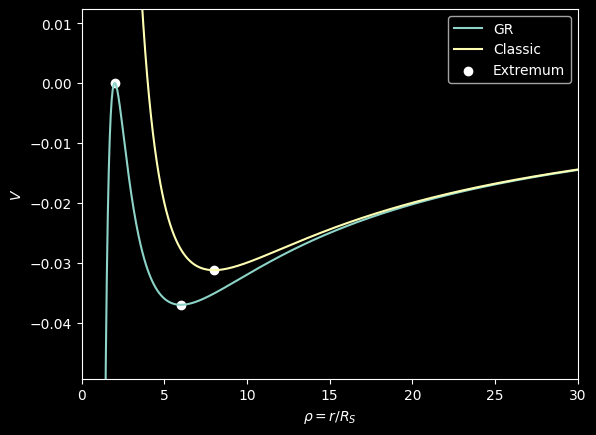

In [3]:
N = 1000
rho = np.linspace(1, 30, N)
l = 2

# Evaluate potentials
VGR = GR(rho, l)
VCM = Vclassical(rho, l)

# Max/min
# Classical mechanics
rhoCM_min = 2*l**2
VCM_min = -0.125/l**2
# General relativity
rho_min = l**2 + l*(l**2 - 3)**.5
VGR_min = GR(rho_min, l)
rho_max = l**2 - l*(l**2 - 3)**.5
VGR_max = GR(rho_max, l)

plt.plot(rho, VGR, label="GR")
plt.plot(rho, VCM, label="Classic")
plt.scatter(rhoCM_min, VCM_min, color='w', label="Extremum")
plt.scatter(rho_min, VGR_min, color='w')
plt.scatter(rho_max, VGR_max, color='w')
# Axes settings
edge = VGR_max - VGR_min
plt.ylabel(r"$V$")
plt.xlabel(r"$\rho=r/R_S$")
plt.ylim([VGR_min - edge/3, VGR_max + edge/3])
plt.xlim([0, rho[-1]])
plt.legend(loc=1)
plt.show()

In [4]:
def getB(x, y, u, v):
    l2 = (x*v - y*u)**2
    return 3*l2

def getA():
    return .5

def RHS(Z, A, B):  
    rho = np.sqrt(Z[0]**2 + Z[1]**2)
    correction = 1 + B/rho**2
    dUdtau = -A*Z[0]/rho**3*correction
    dVdtau = -A*Z[1]/rho**3*correction
    
    return np.array([Z[2], Z[3], dUdtau, dVdtau])

def rk4step(f, y, h, A, B):
    s1 = f(y, A, B)
    s2 = f(y + h*s1/2.0, A, B)
    s3 = f(y + h*s2/2.0, A, B)
    s4 = f(y + h*s3, A, B)
    
    return y + h/6.0*(s1 + 2.0*s2 + 2.0*s3 + s4)

def getOrbit(n, T_max, Z0, fit = 'n'):
    if fit == 'n':
        B = 0
    else:
        B = getB(*Z0)
    print("GR correction constant: %.2e"%(B))
    A = getA()
    
    h = T_max/float(n)
    Z = np.zeros((4, n + 1))
    Z[:, 0] = Z0

    tic = time.time()
    for i in range(0, n):
        Z[:, i + 1] = rk4step(RHS, Z[:, i], h, A, B)
    print("%.5f s, run time with %i steps."% (time.time() - tic, n))
    
    return Z

In [5]:
def plotOrbit(Z_gr, Z_n, lim_fact):
    # Trajectory
    plt.figure(figsize=(15, 15))
    plt.title("Orbit")
    plt.plot(Z_n[0, :], Z_n[1, :], label="Classic")
    plt.plot(Z_gr[0, :], Z_gr[1, :], label="GR")
    plt.plot(Z_n[0, 0], Z_n[1, 0], "o", label="Start")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.plot(0, 0, ".", label="Origin")
    plt.legend()
    plt.savefig("orbit.png", transparent = True)
    plt.show()

GR correction constant: 1.20e+01
0.02864 s, run time with 1000 steps.
GR correction constant: 0.00e+00
0.07442 s, run time with 1000 steps.


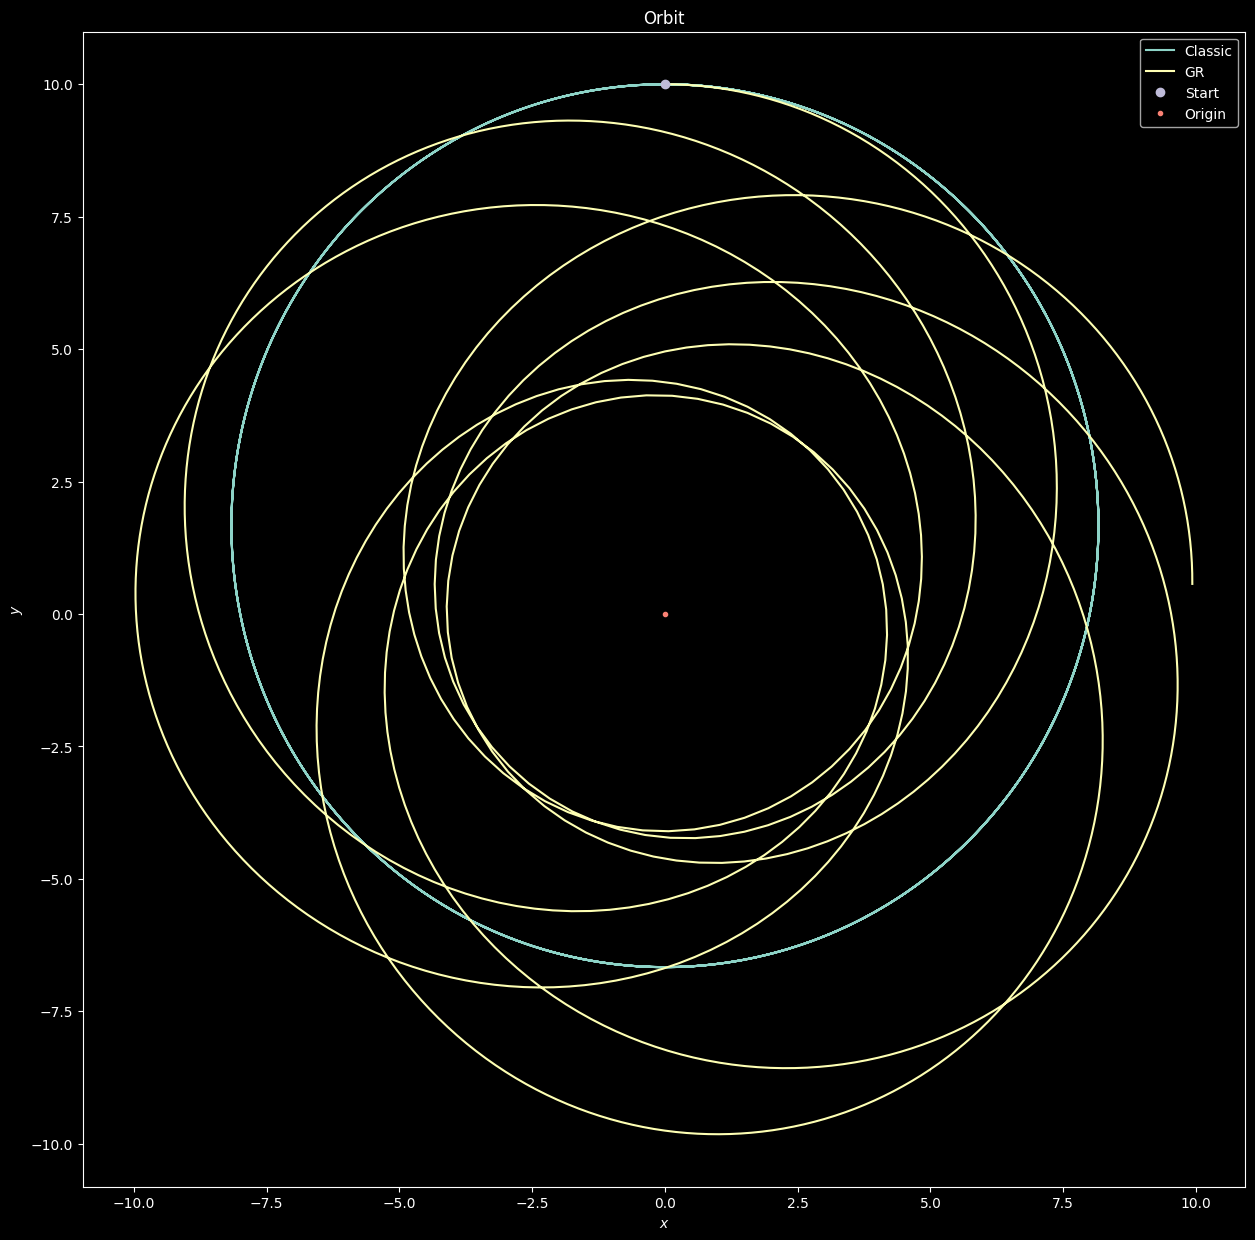

In [6]:
Z0 = [0, 10, .2, 0]
n = 1000
tau_max = 1000
Z_gr = getOrbit(n, tau_max, Z0, fit = 'GR')
Z_n = getOrbit(n, tau_max, Z0, fit = 'n')
plotOrbit(Z_gr, Z_n, 1.1)

In [7]:
def animate_orbit(Z_gr, Z_n, interval=5, l = 100):
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.patch.set_alpha(0)  # Set the figure background to transparent
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_aspect('equal')
    ax.plot(0, 0, '.', label='Origin')

    classic_line, = ax.plot([], [], 'w-', label='Classic')
    gr_line, = ax.plot([], [], 'y-', label='GR')
    classic_point, = ax.plot([], [], 'wo')
    gr_point, = ax.plot([], [], 'yo')
    ax.legend()

    def ff(x):
        return 0 if x <= 0 else x

    def update(frame):
        classic_line.set_data(Z_n[0, ff(frame-l):frame], Z_n[1, ff(frame-l):frame])
        gr_line.set_data(Z_gr[0, ff(frame-l):frame], Z_gr[1, ff(frame-l):frame])
        classic_point.set_data(Z_n[0, frame], Z_n[1, frame])
        gr_point.set_data(Z_gr[0, frame], Z_gr[1, frame])
        return classic_line, gr_line, classic_point, gr_point

    anim = FuncAnimation(fig, update, frames=len(Z_n[0]), interval=interval, blit=True)
    anim.save('orbit.gif', writer='imagemagick')



GR correction constant: 1.20e+01
0.05072 s, run time with 700 steps.
GR correction constant: 0.00e+00
0.05448 s, run time with 700 steps.


/tmp/ipykernel_10930/2401899574.py:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  classic_point.set_data(Z_n[0, frame], Z_n[1, frame])
/tmp/ipykernel_10930/2401899574.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  gr_point.set_data(Z_gr[0, frame], Z_gr[1, frame])
/tmp/ipykernel_10930/2401899574.py:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  classic_point.set_data(Z_n[0, frame], Z_n[1, frame])
/tmp/ipykernel_10930/2401899574.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  gr_point.set_data(Z_gr[0, frame], Z_gr[1, frame])


KeyboardInterrupt: 

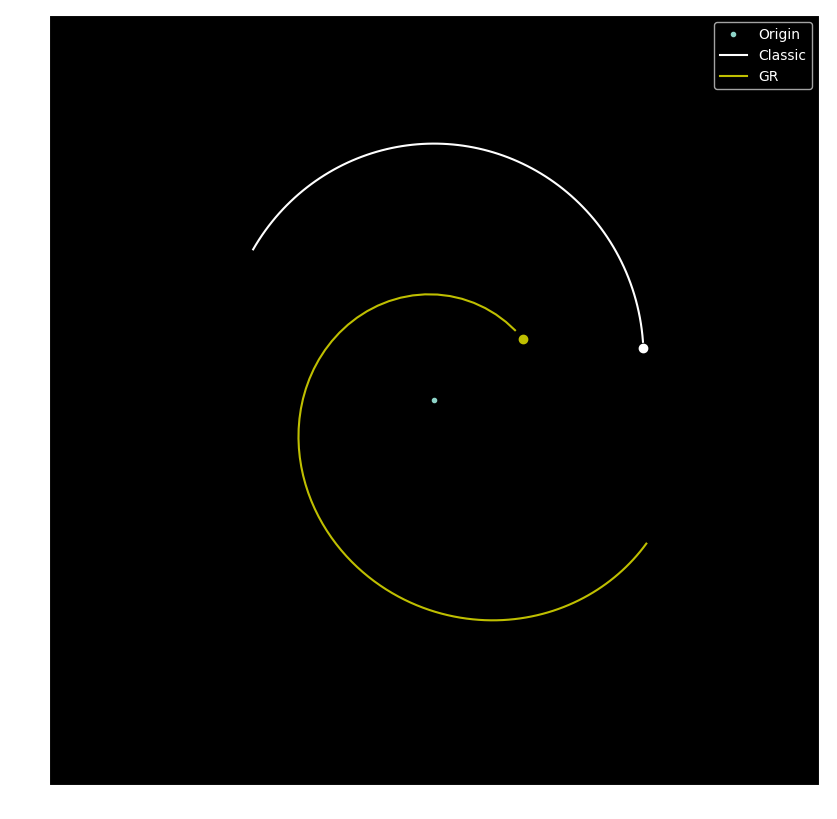

In [8]:
Z0 = [0, 10, .2, 0]
n = 700
tau_max = 700
Z_gr = getOrbit(n, tau_max, Z0, fit = 'GR')
Z_n = getOrbit(n, tau_max, Z0, fit = 'n')

animate_orbit(Z_gr, Z_n)